# Materia obligatoria: Aprendizaje No Supervisado

#### Contenidos

– Clustering

– Embeddings

– Aprendizaje Semi-Supervisado

– Reglas de Asociación

### Práctico entregable

Utilizar la base de jugadores “female_players.csv” disponible en la página de Kaggle https://www.kaggle.com/datasets/stefanoleone992/fifa-23-complete-player-dataset . Consideren que en comparación con la base vista en clase, esta base no tiene los mismos jugadores (ahora mujeres 2023) y no tiene exactamente el mismo formato (a los nombres de las variables se les agregó una keyword para identificar a qué tipo de habilidad corresponde).
Con la nueva base, realizar el siguiente análisis. Notar que es más completo pero análogo al que realizamos con los datos FIFA2019 en el cursado de la materia. Realice comentarios en cada parte (verbose=True ;))

Inicialización del entorno

In [194]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns',200)
pd.set_option('display.max_rows',1000)
import itertools
import warnings
warnings.filterwarnings("ignore")
import io
from plotly.offline import init_notebook_mode, plot,iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)
import matplotlib.pyplot as plt
import plotly.tools as tls#visualization
import plotly.figure_factory as ff#visualization
import seaborn as sns
import plotly.graph_objects as go
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn import decomposition, preprocessing, manifold
from sklearn.preprocessing import StandardScaler
import time

## 1- Análisis exploratorio inicial de la base.

In [195]:
#Carga del dataset
url = 'https://raw.githubusercontent.com/sabrinagdc/DiploDatos/main/No%20Supervisado/female_players.csv'
df = pd.read_csv(url)

In [196]:
df.shape

(181361, 110)

In [197]:
df.head()

,player_id,player_url,fifa_version,fifa_update,fifa_update_date,short_name,long_name,player_positions,overall,potential,value_eur,wage_eur,age,dob,height_cm,weight_kg,league_id,league_name,league_level,club_team_id,club_name,club_position,club_jersey_number,club_loaned_from,club_joined_date,club_contract_valid_until_year,nationality_id,nationality_name,nation_team_id,nation_position,nation_jersey_number,preferred_foot,weak_foot,skill_moves,international_reputation,work_rate,body_type,real_face,release_clause_eur,player_tags,player_traits,pace,shooting,passing,dribbling,defending,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,goalkeeping_speed,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,gk,player_face_url
0,227125,/player/227125/sam-kerr/230009,23,9,2023-01-13,S. Kerr,Samantha May Kerr,ST,91,91,134500000.0,4000.0,28,1993-09-10,168,66,2216.0,Women's Super League,1.0,116010.0,Chelsea W,ST,20.0,NaN,2020-01-01,2024.0,195,Australia,NaN,NaN,NaN,Right,4,4,5,High/High,Normal (170-),Yes,275700000.0,"#Aerial Threat, #Dribbler, #Engine, #Distance ...","Solid Player, Leadership, Finesse Shot, Speed ...",87.0,91.0,74.0,90.0,42.0,83.0,70,93,91,78,92,90,76,68,64,92,89,85,90,91,82,91,91,87,86,89,70,24,95,79,75,92.0,44,39,30,7,12,8,16,13,NaN,91,91,91,87,89,89,89,87,86+3,86+3,86+3,85+3,78+3,78+3,78+3,85+3,64+3,62+3,62+3,62+3,64+3,61+3,58+3,58+3,58+3,61+3,20+3,https://cdn.sofifa.net/players/227/125/23_120.png
1,227316,/player/227316/wendie-renard/230009,23,9,2023-01-13,W. Renard,Wéndèleine Thérèse Renard,CB,91,91,89500000.0,3000.0,31,1990-07-20,187,70,2218.0,Feminine Division 1,1.0,116033.0,Lyon W,LCB,3.0,NaN,2006-07-01,2026.0,18,France,113003.0,LCB,3.0,Right,3,2,5,High/Medium,Lean (185+),Yes,183500000.0,"#Aerial Threat, #Tackling, #Tactician, #Streng...","Leadership, Long Passer (AI), Power Header, Te...",63.0,72.0,71.0,72.0,93.0,87.0,51,70,96,84,55,69,65,58,87,85,65,62,53,90,34,85,86,75,93,65,88,90,70,59,75,84.0,93,94,91,7,14,17,11,15,NaN,78+3,78+3,78+3,71,75,75,75,71,74+3,74+3,74+3,72+3,79+3,79+3,79+3,72+3,80+3,87+3,87+3,87+3,80+3,82+3,91,91,91,82+3,21+3,https://cdn.sofifa.net/players/227/316/23_120.png
2,226301,/player/226301/alex-morgan/230009,23,9,2023-01-13,A. Morgan,Alexandra Morgan Carrasco,ST,90,90,NaN,NaN,32,1989-07-02,168,62,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,95,United States,113009.0,ST,13.0,Left,4,4,5,High/Low,Unique,Yes,NaN,#Clinical Finisher,"Leadership, Finesse Shot, Flair, Speed Dribble...",89.0,91.0,80.0,88.0,47.0,77.0,71,95,86,91,87,87,68,70,82,93,88,89,83,84,67,90,81,87,81,83,53,46,92,75,88,92.0,41,43,39,11,11,10,10,11,NaN,90,90,90,87,89,89,89,87,87+3,87+3,87+3,86+3,82+3,82+3,82+3,86+3,69+3,67+3,67+3,67+3,69+3,66+3,60+3,60+3,60+3,66+3,19+3,https://cdn.sofifa.net/players/226/301/23_120.png
3,227310,/player/227310/ada-hegerberg/230009,23,9,2023-01-13,A. Hegerberg,Ada Martine Stolsmo Hegerberg,ST,90,91,143000000.0,3000.0,26,1995-07-10,176,68,2218.0,Feminine Division 1,1.0,116033.0,Lyon W,RES,14.0,NaN,2014-07-01,2024.0,36,Norway,113007.0,ST,14.0,Right,4,4,5,High/Medium,Normal (170-185),Yes,303900000.0,"#Aerial Threat, #Distance Shooter, #Clinical F...","Leadership, Outside Foot Shot, Technical Dribb...",83.0,91.0,77.0,87.0,39.0,77.0,71,94,93,84,90,91,79,75,72,91,81,85,74,92,47,86,89,75,81,89,65,23,96,76,86,86.0,42,33,30,15,7,12,10,14,NaN,90+1,90+1,90+1,87,89

En esta visualizacion rápida de tabla podemos ver que el dataset contiene diferentes versiones de FIFA, lo cual nos hace sospechar que las jugadoras estan repetidas en cada actualización. Por lo tanto como paso siguiente chequeamos cuantos valores unicos hay de player_id

In [198]:
df.player_id.nunique()

1635

La cantidad de valores unicos para jugadores es mucho menor que el total de filas de data set. Filtramos un ejemplo para corroborar que realmente es la misma jugadora y chequear que es lo que se diferencia en cada fila.

In [199]:
filtered_player_id = df[df['player_id'] == 228723]
filtered_player_id

,player_id,player_url,fifa_version,fifa_update,fifa_update_date,short_name,long_name,player_positions,overall,potential,value_eur,wage_eur,age,dob,height_cm,weight_kg,league_id,league_name,league_level,club_team_id,club_name,club_position,club_jersey_number,club_loaned_from,club_joined_date,club_contract_valid_until_year,nationality_id,nationality_name,nation_team_id,nation_position,nation_jersey_number,preferred_foot,weak_foot,skill_moves,international_reputation,work_rate,body_type,real_face,release_clause_eur,player_tags,player_traits,pace,shooting,passing,dribbling,defending,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,goalkeeping_speed,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,gk,player_face_url
133994,228723,/player/228723/fabiola-ibarra/170099,17,99,2017-09-20,F. Ibarra,Claudia Fabiola Ibarra Muro,LM,64,69,NaN,NaN,22,1994-02-02,164,60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,83,Mexico,113010.0,SUB,22.0,Left,3,3,1,Medium/Medium,Normal (170-),No,NaN,NaN,NaN,78.0,60.0,57.0,61.0,25.0,48.0,62,62,60,55,49,62,40,36,61,57,75,81,66,63,69,59,64,69,41,55,37,27,64,63,73,53.0,16,22,18,5,7,9,10,11,NaN,61+1,61+1,61+1,63,62,62,62,63,61+1,61+1,61+1,63+1,57+1,57+1,57+1,63+1,48+1,43+1,43+1,43+1,48+1,45+1,36+1,36+1,36+1,45+1,14+1,https://cdn.sofifa.net/players/228/723/17_120.png
134311,228723,/player/228723/fabiola-ibarra/170098,17,98,2017-09-18,F. Ibarra,Claudia Fabiola Ibarra Muro,LM,64,69,NaN,NaN,22,1994-02-02,164,60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,83,Mexico,113010.0,SUB,22.0,Left,3,3,1,Medium/Medium,Normal (170-),No,NaN,NaN,NaN,78.0,60.0,57.0,61.0,25.0,48.0,62,62,60,55,49,62,40,36,61,57,75,81,66,63,69,59,64,69,41,55,37,27,64,63,73,53.0,16,22,18,5,7,9,10,11,NaN,61+1,61+1,61+1,63,62,62,62,63,61+1,61+1,61+1,63+1,57+1,57+1,57+1,63+1,48+1,43+1,43+1,43+1,48+1,45+1,36+1,36+1,36+1,45+1,14+1,https://cdn.sofifa.net/players/228/723/17_120.png
134628,228723,/player/228723/fabiola-ibarra/170097,17,97,2017-09-13,F. Ibarra,Claudia Fabiola Ibarra Muro,LM,64,69,NaN,NaN,22,1994-02-02,164,60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,83,Mexico,113010.0,SUB,22.0,Left,3,3,1,Medium/Medium,Normal (170-),No,NaN,NaN,NaN,78.0,60.0,57.0,61.0,25.0,48.0,62,62,60,55,49,62,40,36,61,57,75,81,66,63,69,59,64,69,41,55,37,27,64,63,73,53.0,16,22,18,5,7,9,10,11,NaN,61+1,61+1,61+1,63,62,62,62,63,61+1,61+1,61+1,63+1,57+1,57+1,57+1,63+1,48+1,43+1,43+1,43+1,48+1,45+1,36+1,36+1,36+1,45+1,14+1,https://cdn.sofifa.net/players/228/723/17_120.png
134945,228723,/player/228723/fabiola-ibarra/170096,17,96,2017-09-11,F. Ibarra,Claudia Fabiola Ibarra Muro,LM,64,69,NaN,NaN,22,1994-02-02,164,60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,83,Mexico,113010.0,SUB,22.0,Left,3,3,1,Medium/Medium,Normal (170-),No,NaN,NaN,NaN,78.0,60.0,57.0,61.0,25.0,48.0,62,62,60,55,49,62,40,36,61,57,75,81,66,63,69,59,64,69,41,55,37,27,64,63,73,53.0,16,22,18,5,7,9,10,11,NaN,61+1,61+1,61+1,63,62,62,62,63,61+1,61+1,61+1,63+1,57+1,57+1,57+1,63+1,48+1,43+1,43+1,43+1,48+1,45+1,36+1,36+1,36+1,45+1,14+1,https://cdn.sofifa.net/players/228/723/17_120.png
135262,228723,/player/228723/fabiola-ibarra/170095,17,95,2017-09-07,F. Ibarra,Claudia Fabiola Ibarra Muro,LM,64,69,NaN,NaN,22,1994-02-02,164,60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,83,Mexico,113010.0,SUB,22.0,Left,3,3,1,Medium/Medium,Normal (170-),No,NaN,NaN,NaN,78.0,60.0,57.0,61.0,25.0,48.0,62,62,

Se trata de la misma jugadora y varía la versión de actualización de FIFA. Teniendo esto en mente, decidimos filtrar para quedarnos con una unica versión que represente a un unico jugador.

In [200]:
df_sorted = df.sort_values(by='fifa_update_date', ascending=False)
# Drop duplicates in 'player_id', keeping the last occurrence (latest 'fifa_update_date')
df_player_last_update = df_sorted.drop_duplicates(subset='player_id', keep='first').reset_index(drop=True)
df_player_last_update. head(3)

,player_id,player_url,fifa_version,fifa_update,fifa_update_date,short_name,long_name,player_positions,overall,potential,value_eur,wage_eur,age,dob,height_cm,weight_kg,league_id,league_name,league_level,club_team_id,club_name,club_position,club_jersey_number,club_loaned_from,club_joined_date,club_contract_valid_until_year,nationality_id,nationality_name,nation_team_id,nation_position,nation_jersey_number,preferred_foot,weak_foot,skill_moves,international_reputation,work_rate,body_type,real_face,release_clause_eur,player_tags,player_traits,pace,shooting,passing,dribbling,defending,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,goalkeeping_speed,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,gk,player_face_url
0,227125,/player/227125/sam-kerr/230009,23,9,2023-01-13,S. Kerr,Samantha May Kerr,ST,91,91,134500000.0,4000.0,28,1993-09-10,168,66,2216.0,Women's Super League,1.0,116010.0,Chelsea W,ST,20.0,NaN,2020-01-01,2024.0,195,Australia,NaN,NaN,NaN,Right,4,4,5,High/High,Normal (170-),Yes,275700000.0,"#Aerial Threat, #Dribbler, #Engine, #Distance ...","Solid Player, Leadership, Finesse Shot, Speed ...",87.0,91.0,74.0,90.0,42.0,83.0,70,93,91,78,92,90,76,68,64,92,89,85,90,91,82,91,91,87,86,89,70,24,95,79,75,92.0,44,39,30,7,12,8,16,13,NaN,91,91,91,87,89,89,89,87,86+3,86+3,86+3,85+3,78+3,78+3,78+3,85+3,64+3,62+3,62+3,62+3,64+3,61+3,58+3,58+3,58+3,61+3,20+3,https://cdn.sofifa.net/players/227/125/23_120.png
1,265164,/player/265164/marina-georgieva/230009,23,9,2023-01-13,M. Georgieva,Marina Georgieva,CB,75,80,7500000.0,700.0,25,1997-04-13,174,67,2218.0,Feminine Division 1,1.0,116034.0,Paris SG W,SUB,23.0,NaN,2022-08-11,2024.0,4,Austria,NaN,NaN,NaN,Right,3,2,1,Medium/High,Stocky (170-185),No,15900000.0,NaN,NaN,68.0,44.0,61.0,67.0,75.0,80.0,59,42,68,75,42,65,51,38,69,69,67,69,72,72,66,58,74,65,88,37,78,72,39,42,44,60.0,75,78,76,13,8,10,8,10,NaN,59+2,59+2,59+2,60,58,58,58,60,60+2,60+2,60+2,62+2,63+2,63+2,63+2,62+2,70+2,72+2,72+2,72+2,70+2,71+2,75+2,75+2,75+2,71+2,17+2,https://cdn.sofifa.net/players/265/164/23_120.png
2,269657,/player/269657/gudhrun-arnardottir/230009,23,9,2023-01-13,G. Arnardóttir,Guðrún Arnardóttir,CB,73,75,NaN,NaN,26,1995-07-29,171,68,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24,Iceland,116428.0,SUB,18.0,Right,3,2,1,Medium/High,Normal (170-185),No,NaN,NaN,NaN,71.0,34.0,58.0,69.0,76.0,70.0,32,34,71,75,30,68,31,42,68,76,71,71,68,75,51,33,58,77,69,35,66,74,27,58,51,58.0,82,75,71,9,11,9,13,7,NaN,54+2,54+2,54+2,58,58,58,58,58,62+2,62+2,62+2,62+2,66+2,66+2,66+2,62+2,69+2,73+2,73+2,73+2,69+2,71+2,73+2,73+2,73+2,71+2,17+2,https://cdn.sofifa.net/players/269/657/23_120.png


In [201]:
for col in df_player_last_update.columns:
  print(col)

player_id
player_url
fifa_version
fifa_update
fifa_update_date
short_name
long_name
player_positions
overall
potential
value_eur
wage_eur
age
dob
height_cm
weight_kg
league_id
league_name
league_level
club_team_id
club_name
club_position
club_jersey_number
club_loaned_from
club_joined_date
club_contract_valid_until_year
nationality_id
nationality_name
nation_team_id
nation_position
nation_jersey_number
preferred_foot
weak_foot
skill_moves
international_reputation
work_rate
body_type
real_face
release_clause_eur
player_tags
player_traits
pace
shooting
passing
dribbling
defending
physic
attacking_crossing
attacking_finishing
attacking_heading_accuracy
attacking_short_passing
attacking_volleys
skill_dribbling
skill_curve
skill_fk_accuracy
skill_long_passing
skill_ball_control
movement_acceleration
movement_sprint_speed
movement_agility
movement_reactions
movement_balance
power_shot_power
power_jumping
power_stamina
power_strength
power_long_shots
mentality_aggression
mentality_interceptio

In [202]:
if df_player_last_update.duplicated().any():
    print("Hay filas duplicadas en el DataFrame.")
else:
    print("No hay filas duplicadas en el DataFrame.")

No hay filas duplicadas en el DataFrame.


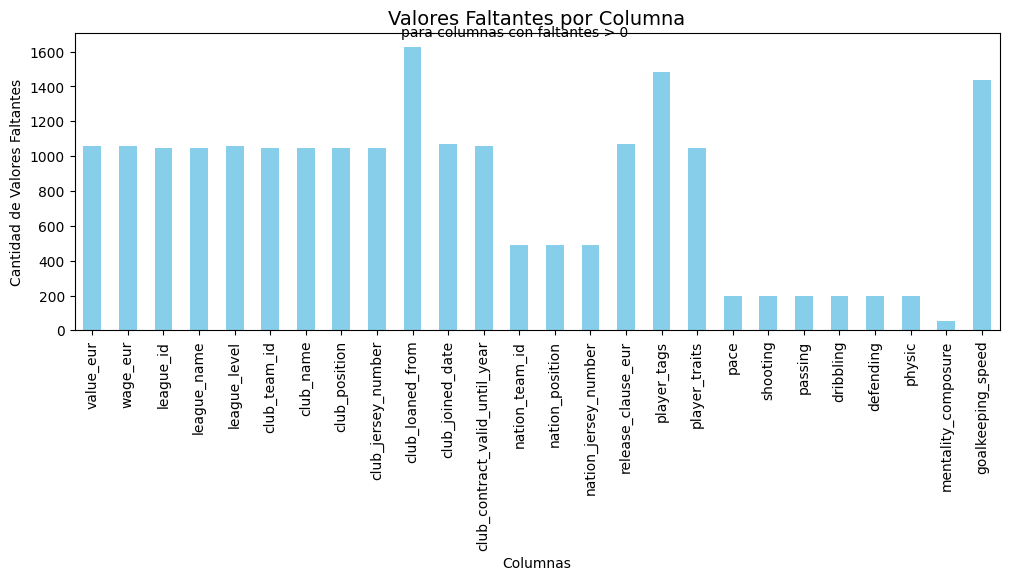

In [203]:
# Cálculo de la cantidad de valores faltantes en cada columna
missing_values = df_player_last_update.isnull().sum()

# Filtrado de las columnas con valores faltantes
columns_with_missing = missing_values[missing_values > 0]

# Gráfico de barras sólo para las columnas con valores faltantes
plt.figure(figsize=(10, 6))
columns_with_missing.plot(kind='bar', color='skyblue')
plt.title('Valores Faltantes por Columna', fontsize=14)
plt.suptitle('para columnas con faltantes > 0', fontsize=10, y=0.90)
plt.tight_layout()
plt.xlabel('Columnas')
plt.ylabel('Cantidad de Valores Faltantes')
plt.xticks(rotation=90)
plt.show()

In [204]:
#descartamos las columnas que tienen más de 1000 missing values e irrelevantes (nombres, etc)
descartar = ['value_eur','wage_eur','league_id','league_level','club_team_id','club_name','club_position','club_jersey_number',
             'club_loaned_from', 'club_joined_date','club_contract_valid_until_year','release_clause_eur','player_tags',
             'player_traits','goalkeeping_speed', 'short_name', 'long_name','player_face_url','fifa_version',
             'fifa_update','fifa_update_date','player_url','nationality_name','dob', 'nation_team_id',
             'nation_jersey_number', 'league_name', 'nation_position', 'international_reputation', 'real_face', 'body_type',
             'ls', 'st', 'rs', 'lw', 'lf', 'cf', 'rf', 'rw', 'lam', 'cam', 'ram', 'lm', 'lcm', 'cm', 'rcm', 'rm', 'lwb', 'ldm',
             'cdm', 'rdm', 'rwb', 'lb', 'lcb', 'cb', 'rcb', 'rb', 'gk','player_id'] #, 'nationality_id'

col_name = df_player_last_update['short_name'] #guardamos los nombres para las visualizaciones
df_player_last_update.drop(columns=descartar, axis=1, inplace=True)

In [205]:
df_player_last_update.head()

,player_positions,overall,potential,age,height_cm,weight_kg,nationality_id,preferred_foot,weak_foot,skill_moves,work_rate,pace,shooting,passing,dribbling,defending,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes
0,ST,91,91,28,168,66,195,Right,4,4,High/High,87.0,91.0,74.0,90.0,42.0,83.0,70,93,91,78,92,90,76,68,64,92,89,85,90,91,82,91,91,87,86,89,70,24,95,79,75,92.0,44,39,30,7,12,8,16,13
1,CB,75,80,25,174,67,4,Right,3,2,Medium/High,68.0,44.0,61.0,67.0,75.0,80.0,59,42,68,75,42,65,51,38,69,69,67,69,72,72,66,58,74,65,88,37,78,72,39,42,44,60.0,75,78,76,13,8,10,8,10
2,CB,73,75,26,171,68,24,Right,3,2,Medium/High,71.0,34.0,58.0,69.0,76.0,70.0,32,34,71,75,30,68,31,42,68,76,71,71,68,75,51,33,58,77,69,35,66,74,27,58,51,58.0,82,75,71,9,11,9,13,7
3,GK,73,79,25,182,70,37,Right,2,1,Medium/Medium,NaN,NaN,NaN,NaN,NaN,NaN,12,13,11,31,8,17,16,12,24,22,34,45,42,63,45,54,69,32,42,8,22,14,9,41,19,33.0,10,15,13,76,70,72,72,75
4,GK,73,81,22,169,74,18,Right,2,1,Medium/Medium,NaN,NaN,NaN,NaN,NaN,NaN,13,11,12,26,9,13,16,14,21,17,37,42,38,69,45,50,51,32,68,10,29,13,11,31,19,41.0,15,13,11,73,70,66,72,77


In [206]:
#volvemos a mirar las columnas, habiendo descartado algunas
df_player_last_update.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1635 entries, 0 to 1634
Data columns (total 51 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   player_positions             1635 non-null   object 
 1   overall                      1635 non-null   int64  
 2   potential                    1635 non-null   int64  
 3   age                          1635 non-null   int64  
 4   height_cm                    1635 non-null   int64  
 5   weight_kg                    1635 non-null   int64  
 6   nationality_id               1635 non-null   int64  
 7   preferred_foot               1635 non-null   object 
 8   weak_foot                    1635 non-null   int64  
 9   skill_moves                  1635 non-null   int64  
 10  work_rate                    1635 non-null   object 
 11  pace                         1435 non-null   float64
 12  shooting                     1435 non-null   float64
 13  passing           

In [207]:
display(df_player_last_update.shape)
df_player_last_update.describe()

(1635, 51)

,overall,potential,age,height_cm,weight_kg,nationality_id,weak_foot,skill_moves,pace,shooting,passing,dribbling,defending,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes
count,1635.000000,1635.000000,1635.000000,1635.000000,1635.000000,1635.000000,1635.000000,1635.000000,1435.000000,1435.000000,1435.000000,1435.000000,1435.000000,1435.000000,1635.000000,1635.000000,1635.000000,1635.000000,1635.000000,1635.000000,1635.000000,1635.000000,1635.000000,1635.000000,1635.000000,1635.000000,1635.000000,1635.000000,1635.000000,1635.000000,1635.000000,1635.000000,1635.000000,1635.000000,1635.000000,1635.000000,1635.000000,1635.000000,1635.000000,1583.000000,1635.000000,1635.000000,1635.000000,1635.000000,1635.000000,1635.000000,1635.000000,1635.000000
mean,73.976147,77.833639,25.882569,168.201835,60.795107,64.384098,3.064832,2.596942,70.758188,59.283624,64.276655,68.935192,57.583275,66.282927,54.406728,52.571865,57.093578,66.351070,46.379817,60.183486,51.122324,47.839755,58.180428,65.760856,66.278287,66.924771,63.955352,71.298471,69.473394,60.880122,66.174924,65.734557,65.128440,52.771254,55.718654,51.533945,55.507645,58.369419,53.798165,62.820594,50.770031,53.092355,49.988379,18.071560,18.011621,17.912538,18.012844,18.356575
std,5.965736,5.648883,4.505637,6.221896,5.543550,55.927173,0.623454,0.880005,9.361748,15.905307,9.938134,9.602670,19.364031,8.832911,20.687045,23.697480,20.330872,17.434341,21.355176,21.690193,20.045626,18.400149,18.102384,19.384682,14.865336,14.573365,13.798953,8.221622,12.559420,15.392668,10.457642,15.426114,12.719481,22.396484,19.054110,25.241149,23.779828,16.511056,17.550999,14.418502,24.642878,24.956327,24.222939,20.760283,20.374655,20.157679,20.653354,21.203437
min,57.000000,59.000000,16.000000,151.000000,45.000000,4.000000,1.000000,1.000000,33.000000,20.000000,28.000000,33.000000,16.000000,36.000000,5.000000,4.000000,6.000000,11.000000,4.000000,4.000000,8.000000,8.000000,14.000000,8.000000,15.000000,16.000000,21.000000,37.000000,27.000000,13.000000,15.000000,14.000000,23.000000,5.000000,12.000000,4.000000,4.000000,10.000000,10.000000,11.000000,5.000000,7.000000,8.000000,5.000000,5.000000,5.000000,5.000000,5.000000
25%,70.000000,74.000000,22.000000,164.000000,57.000000,18.000000,3.000000,2.000000,65.000000,48.000000,58.000000,64.000000,40.000000,61.000000,42.000000,34.000000,48.000000,64.000000,30.000000,55.000000,37.000000,36.000000,49.000000,64.000000,60.000000,62.000000,57.000000,67.000000,63.000000,52.000000,59.000000,62.000000,58.000000,37.000000,42.000000,25.000000,41.000000,47.000000,44.000000,56.000000,28.000000,29.000000,27.000000,8.000000,8.000000,8.000000,8.000000,8.000000
50%,74.000000,78.000000,26.000000,168.000000,60.000000,45.000000,3.000000,3.000000,71.000000,63.000000,65.000000,70.000000,64.000000,67.000000,59.000000,59.000000,63.000000,71.000000,48.000000,67.000000,56.000000,50.000000,64.000000,71.000000,69.000000,70.000000,66.000000,72.000000,72.000000,63.000000,67.000000,69.000000,67.000000,60.000000,59.000000,63.000000,64.000000,61.000000,56.000000,65.000000,57.000000,64.000000,56.000000,11.000000,11.000000,11.000000,11.000000,11.000000
75%,78.000000,82.000000,29.000000,173.000000,65.000000,83.000000,3.000000,3.000000,77.000000,72.000000,71.000000,75.000000,74.000000,73.000000,70.000000,72.000000,71.000000,77.000000,64.000000,75.000000,67.000000,61.000000,72.000000,77

Si bien muchas de las variables estan en un rango de porcentaje entre 0 y 100, si deseamos realizar una comparación primero deberian pasar por una estandarización.

In [208]:
#cuántos valores únicos tiene cada una de las variables del dataset?
# Cantidad de valores únicos por variable
print("Cantidad de valores únicos por variable:")
uniques_table = df_player_last_update.nunique().sort_values(ascending=True)
uniques_table

Cantidad de valores únicos por variable:


preferred_foot                   2
weak_foot                        5
skill_moves                      5
work_rate                        9
age                             25
potential                       35
overall                         36
height_cm                       38
weight_kg                       38
goalkeeping_handling            46
goalkeeping_diving              46
goalkeeping_reflexes            47
goalkeeping_kicking             48
goalkeeping_positioning         51
physic                          53
nationality_id                  54
movement_reactions              55
dribbling                       57
passing                         58
pace                            60
power_jumping                   64
movement_balance                69
power_strength                  70
shooting                        72
movement_agility                72
mentality_composure             77
defending                       77
attacking_short_passing         78
power_stamina       

Al tener valores únicos en un orden de magnitud 10 veces menor al número de filas, podemos sospechar que va haber clusterización o conjunción de ciertos atributos para las diferentes jugadoras.

<Axes: title={'center': 'Mapa de calor de la matriz de correlación'}>

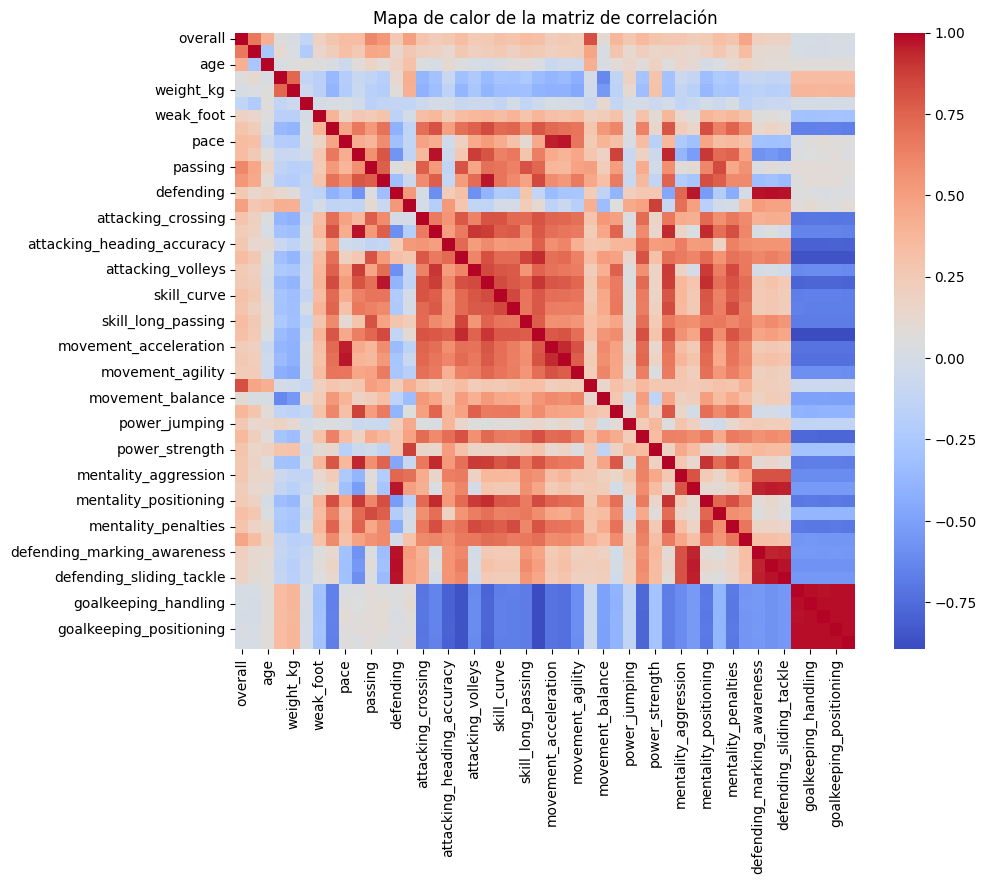

In [209]:
#matriz de correlaciones
correlation_matrix = df_player_last_update.corr()
# Crea el mapa de calor
plt.figure(figsize=(10, 8))
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title("Mapa de calor de la matriz de correlación")
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')

El mapa de calor nos deja ver que hay alta correlación entre variables por lo cual puede ser beneficioso ampliar el filtro de atributos o hacer embedding

## 2- Evaluación visual


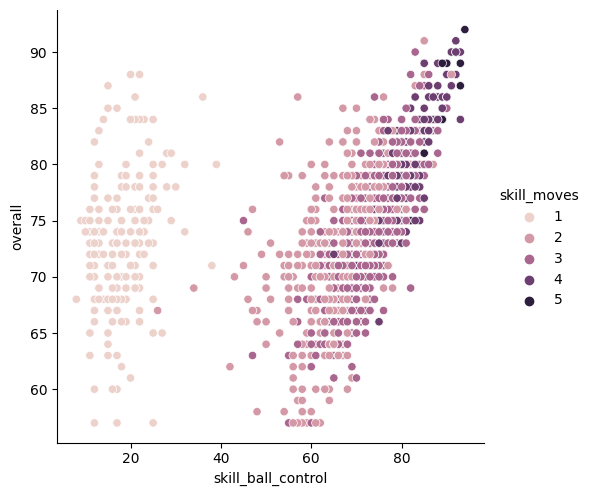

In [210]:
sns.pairplot(df_player_last_update, x_vars=["skill_ball_control"], y_vars=["overall"], hue="skill_moves", height=5)

En este gráfico podemos visualizar dos conjuntos distintos. Uno de ellos que posee bajo control del balón y movimientos pero que la calificación total (overall) es variable, el cual quizás se trate de arqueras. El otro conjunto parecería mostrar una correlación positiva entre control del balón, movimientos y el overall.

<Axes: xlabel='skill_ball_control', ylabel='power_shot_power'>

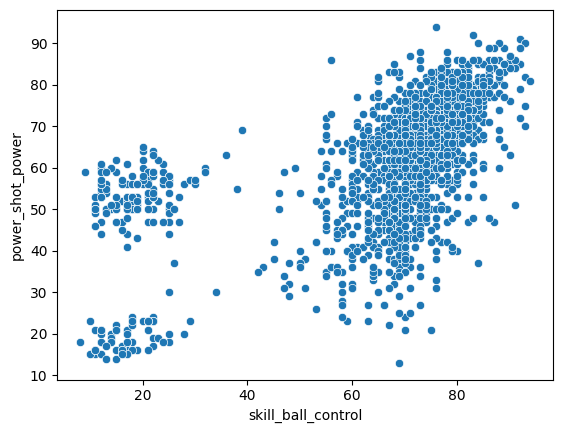

In [211]:
#scatterplot entre skill_ball_control y power_shot_power
sns.scatterplot(x='skill_ball_control', y='power_shot_power', data=df_player_last_update)

En este gráfico parecería que podemos distinguir tres conjuntos. Uno de ellos posee baja potencia de tiro y bajo control de pelota. Otro de ellos también tiene bajo control pero la potencia de tiro en intermedia. Mientras que el último conjunto posee mucho mejor control de pelota y se ve una ligera tendencia de que las jugadoras con mayor control tienen mayor potencia.

<Axes: xlabel='physic', ylabel='dribbling'>

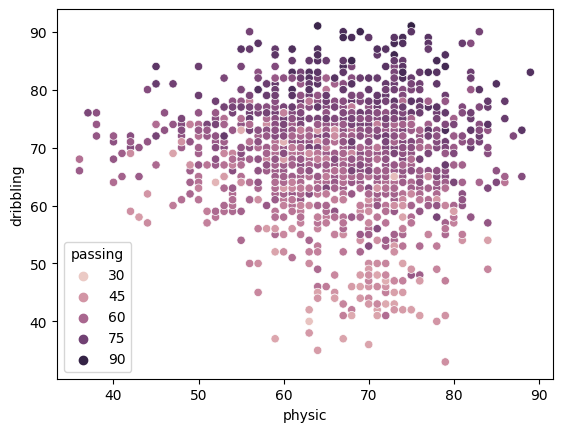

In [212]:
#scatterplot entre physic y dribbling, donde se distingue por color el passing
sns.scatterplot(x='physic', y='dribbling',hue='passing', data=df_player_last_update)

En este gráfico no se observa división entre las jugadoras. Lo que sí se puede observar es que el físico no pareciera tener correlación ni con el dribbling ni el passing de las jugadoras pero sí hay una correlación positiva entre dribbling y passing entre sí.

<Axes: xlabel='pace', ylabel='movement_reactions'>

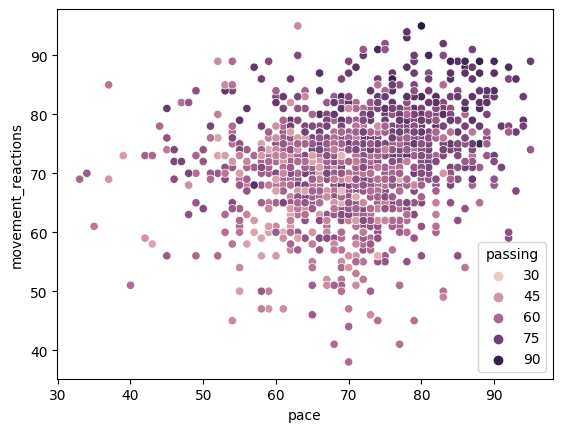

In [213]:
#scatterplot entre pacec y movement_reactions, donde se distingue por color el passing
sns.scatterplot(x='pace', y='movement_reactions', hue='passing', data=df_player_last_update)

En este gráfico tampoco se observa división en conjuntos. Se observa una correlación positiva entre passing y la reacción en movimientos, pero ninguna de estas dos parece correlacionarse con la  velocidad (pace).

<Axes: xlabel='attacking_heading_accuracy', ylabel='defending_marking_awareness'>

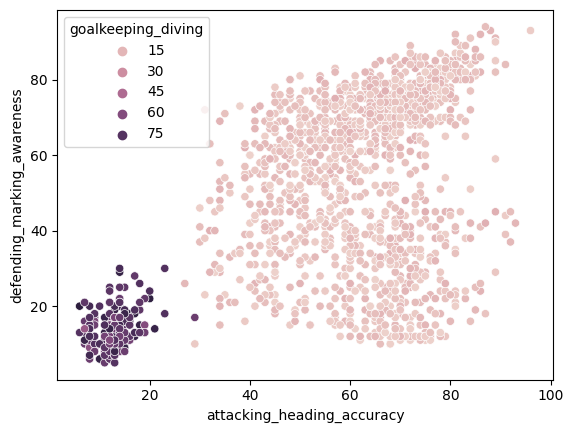

In [214]:
sns.scatterplot(data=df_player_last_update, x="attacking_heading_accuracy", y="defending_marking_awareness", hue="goalkeeping_diving")

En este gráfico podríamos decir que se distinguen tres conjuntos: Las arqueras en violeta oscuro y los otros dos separados entre un grupo que defiende menos que el otro. Esta separación probablemente esté relacionada con la posición en la cancha.

La visualizacion de diversas variables a través de scatterplots nos permite decir que algunas caracteristicas agrupan más que otras. Sin embargo no existen agrupaciones de geometría no plana que justifiquen el uso de DBSCAN o tecnicas jerárquicas, por lo que se decide utilizar Kmeans y Mezcla de Gausseanas para comparar el rendimiento de ambos métodos.

## 3- Curación: Encoding, Imputación y Estandarización

Para poder utilizar Kmeans debemos quedarnos con las variables númericas e imputar faltantes ya que el mismo no acepta Nan.También es conveniente estandarizar para que todas las variables tengan el mismo peso. Asimismo esto nos servirá para realizar el embedding en el siguiente paso.

En primera instancia vamos aplicar get_dummies para encodear las variables categóricas.

In [215]:
df_player_last_update['player_positions'].unique()

array(['ST', 'CB', 'GK', 'CDM, CM', 'CM', 'LW, ST, RW', 'RB, CB',
       'LM, CM', 'ST, RM, LM', 'LW, RW', 'CAM, CM', 'CM, CDM',
       'CM, CAM, CDM', 'LB, CB', 'RB, LB', 'LW, LM', 'CM, RM, LM',
       'CM, LM', 'ST, RM', 'RM, LB, RB', 'ST, LM', 'RM', 'LB',
       'LM, RM, ST', 'CM, CAM', 'CB, LB', 'CDM, CB, CM', 'RW', 'RM, LM',
       'LW, LB', 'RB', 'CB, RB', 'CB, RB, LB', 'RB, RM', 'LB, RB, RWB',
       'CDM, CB', 'RM, CM', 'ST, LW', 'RB, RM, RW', 'LWB, RWB',
       'RM, CAM, ST', 'LW, ST', 'LM, CAM, CM', 'LM, ST', 'RW, RM, CAM',
       'RW, LW', 'LB, CB, RB', 'CAM, ST', 'CF, RM, LM', 'RW, ST, CAM',
       'ST, CAM, LW', 'LW, RW, CAM', 'RM, RW, RWB', 'RM, ST',
       'CAM, CM, CF', 'CDM, RB', 'CF, ST', 'CM, CDM, CAM', 'CDM, LB, CB',
       'CM, CDM, CB', 'ST, RM, CAM', 'CDM', 'CM, CB', 'ST, CAM, LM',
       'CB, CDM', 'LWB', 'ST, LW, CAM', 'RB, RM, LB', 'CM, ST',
       'CAM, RM, CM', 'LM, RM', 'CAM, CM, RW', 'CB, RWB, RB', 'RW, ST',
       'ST, CAM', 'CAM, LM', 'CAM', 'LW, RW, ST'

Al tener tantas posiciones por cada jugadora es sugerible agruparlas en categorías más generales

In [216]:
forwards=['RF', 'ST', 'LW', 'LF', 'RW']
midfielders=['CAM','CM','LM','RM','CDM']
defenders=['CB','LB','RB','RWB','LWB']
goalkeepers=['GK']

def pos2(position):
    if any(valor in position for valor in forwards):
        return 'Forward'

    elif any(valor in position for valor in midfielders):
        return 'Midfielder'

    elif any(valor in position for valor in defenders):
        return 'Defender'

    elif any(valor in position for valor in goalkeepers):
        return 'GK'

    else:
        return 'nan'


df_player_last_update["Position"]=df_player_last_update['player_positions'].apply(lambda x: pos2(x))
df_player_last_update.drop(columns=['player_positions'], axis=1, inplace=True)
df_player_last_update["Position"].value_counts()
col_position = df_player_last_update["Position"] #guardamos antes del getdummies para usar para visualización al final

In [217]:
df_player_last_update = pd.get_dummies(df_player_last_update, columns=['Position'],prefix='Position', drop_first = False)
df_player_last_update = pd.get_dummies(df_player_last_update, columns=['preferred_foot'],prefix='preferred_foot', drop_first = False)
df_player_last_update = pd.get_dummies(df_player_last_update, columns=['work_rate'],prefix='work_rate', drop_first = False)

In [218]:
#Imputamos Nan en variables numéricas por la media de esas variables
df_player_last_update['passing'].fillna(df_player_last_update['passing'].mean(), inplace = True)
df_player_last_update['dribbling'].fillna(df_player_last_update['dribbling'].mean(), inplace = True)
df_player_last_update['defending'].fillna(df_player_last_update['defending'].mean(), inplace = True)
df_player_last_update['physic'].fillna(df_player_last_update['physic'].mean(), inplace = True)
df_player_last_update['mentality_composure'].fillna(df_player_last_update['mentality_composure'].mean(), inplace = True)
df_player_last_update['pace'].fillna(df_player_last_update['pace'].mean(), inplace = True)
df_player_last_update['shooting'].fillna(df_player_last_update['shooting'].mean(), inplace = True)

In [219]:
df_player_last_update.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1635 entries, 0 to 1634
Data columns (total 63 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   overall                      1635 non-null   int64  
 1   potential                    1635 non-null   int64  
 2   age                          1635 non-null   int64  
 3   height_cm                    1635 non-null   int64  
 4   weight_kg                    1635 non-null   int64  
 5   nationality_id               1635 non-null   int64  
 6   weak_foot                    1635 non-null   int64  
 7   skill_moves                  1635 non-null   int64  
 8   pace                         1635 non-null   float64
 9   shooting                     1635 non-null   float64
 10  passing                      1635 non-null   float64
 11  dribbling                    1635 non-null   float64
 12  defending                    1635 non-null   float64
 13  physic            

In [220]:
scaler = StandardScaler()

# Estandarizar las características en el DataFrame
df_estandarizado = scaler.fit_transform(df_player_last_update)

# Crear un nuevo DataFrame con las características estandarizadas
df_estandarizado = pd.DataFrame(df_estandarizado, columns=df_player_last_update.columns)
df_estandarizado.head()

,overall,potential,age,height_cm,weight_kg,nationality_id,weak_foot,skill_moves,pace,shooting,passing,dribbling,defending,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,Position_Defender,Position_Forward,Position_GK,Position_Midfielder,preferred_foot_Left,preferred_foot_Right,work_rate_High/High,work_rate_High/Low,work_rate_High/Medium,work_rate_Low/High,work_rate_Low/Low,work_rate_Low/Medium,work_rate_Medium/High,work_rate_Medium/Low,work_rate_Medium/Medium
0,2.854478,2.331503,0.470095,-0.032449,0.939197,2.336179,1.500438,1.594862,1.852515,2.129246,1.044709,2.342339e+00,-0.859305,2.020881,0.754001,1.706532,1.668241,0.668364,2.136912,1.375075,1.241432,1.095992,0.321579,1.354016,1.528971,1.240672,1.888014,2.397040,0.997692,1.957367,2.374596,1.378957,1.641415,1.618104,0.749745,-1.091169,1.661258,1.249883,1.208383,2.057368,-0.274810,-0.564853,-0.825436,-0.533468,-0.295144,-0.491900,-0.097488,-0.252705,-0.569110,1.535347,-0.373327,-0.710028,-0.460444,0.460444,4.625717,-0.177611,-0.477912,-0.127118,-0.024739,-0.1663,-0.271181,-0.173913,-1.218525
1,0.171675,0.383620,-0.195941,0.932182,1.119642,-1.080022,-0.104020,-0.678547,-0.314595,-1.026050,-0.352055,-2.151871e-01,0.960406,1.658219,0.222104,-0.446254,0.536610,0.496238,-0.205157,0.222127,-0.006104,-0.534929,0.597871,0.167149,0.048565,0.142442,0.583168,0.085353,-0.276642,-0.187167,0.748493,-0.047632,1.798702,-0.704400,1.169730,0.811069,-0.694399,-0.991725,-0.558439,-0.198873,0.983545,0.998355,1.074171,-0.244366,-0.491527,-0.392652,-0.484953,-0.394235,1.757128,-0.651319,-0.373327,-0.710028,-0.460444,0.460444,-0.216183,-0.177611,-0.477912,-0.127118,-0.024739,-0.1663,3.687576,-0.173913,-1.218525
2,-0.163676,-0.501782,0.026071,0.449866,1.300087,-0.722305,-0.104020,-0.678547,0.027581,-1.697390,-0.674385,7.206482e-03,1.015549,0.449347,-1.083460,-0.783946,0.684214,0.496238,-0.767253,0.360481,-1.004133,-0.317473,0.542612,0.528370,0.317730,0.279721,0.293202,0.450357,-1.471330,-1.811814,-0.781957,0.730507,0.304473,-0.793727,0.539752,0.890329,-1.199183,-0.022381,-0.159479,-0.339888,1.267690,0.878108,0.867692,-0.437101,-0.344240,-0.442276,-0.242788,-0.535765,1.757128,-0.651319,-0.373327,-0.710028,-0.460444,0.460444,-0.216183,-0.177611,-0.477912,-0.127118,-0.024739,-0.1663,3.687576,-0.173913,-1.218525
3,-0.163676,0.206540,-0.195941,2.218357,1.660977,-0.489788,-1.708478,-1.815251,0.000000,0.000000,0.000000,1.580202e-15,0.000000,0.000000,-2.050544,-1.670387,-2.267865,-2.028289,-1.797764,-1.991531,-1.752655,-1.948393,-1.888750,-2.258187,-2.172044,-1.504902,-1.591575,-1.009656,-1.949205,-0.447111,0.270227,-2.187516,-1.818904,-1.999642,-1.770168,-1.487469,-1.956359,-1.052309,-1.983295,-2.102576,-1.654941,-1.526828,-1.527465,2.791203,2.552401,2.684040,2.614765,2.672244,-0.569110,-0.651319,2.678619,-0.710028,-0.460444,0.460444,-0.216183,-0.177611,-0.477912,-0.127118,-0.024739,-0.1663,-0.271181,-0.173913,0.820665
4,-0.163676,0.560700,-0.861977,0.128323,2.382757,-0.829620,-1.708478,-1.815251,0.000000,0.000000,0.000000,1.580202e-15,0.000000,0.000000,-2.002190,-1.754810,-2.218664,-2.315167,-1.750922,-2.176003,-1.752655,-1.839665,-2.054525,-2.516202,-1.970170,-1.710820,-1.881541,-0.279650,-1.949205,-0.707054,-1.451529,-2.187516,0.225830,-1.910315,-1.402681,-1.527099,-1.872228,-1.658149,-1.983295,-1.538516,-1.451980,-1.606992,-1.610057,2.646652,2.552401,2.386295,2.614765,2.766597,-0.569

In [221]:
df_estandarizado

,overall,potential,age,height_cm,weight_kg,nationality_id,weak_foot,skill_moves,pace,shooting,passing,dribbling,defending,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,Position_Defender,Position_Forward,Position_GK,Position_Midfielder,preferred_foot_Left,preferred_foot_Right,work_rate_High/High,work_rate_High/Low,work_rate_High/Medium,work_rate_Low/High,work_rate_Low/Low,work_rate_Low/Medium,work_rate_Medium/High,work_rate_Medium/Low,work_rate_Medium/Medium
0,2.854478,2.331503,0.470095,-0.032449,0.939197,2.336179,1.500438,1.594862,1.852515,2.129246,1.044709,2.342339e+00,-0.859305,2.020881,0.754001,1.706532,1.668241,0.668364,2.136912,1.375075,1.241432,1.095992,0.321579,1.354016,1.528971,1.240672,1.888014,2.397040,0.997692,1.957367,2.374596,1.378957,1.641415,1.618104,0.749745,-1.091169,1.661258,1.249883,1.208383,2.057368e+00,-0.274810,-0.564853,-0.825436,-0.533468,-0.295144,-0.491900,-0.097488,-0.252705,-0.569110,1.535347,-0.373327,-0.710028,-0.460444,0.460444,4.625717,-0.177611,-0.477912,-0.127118,-0.024739,-0.1663,-0.271181,-0.173913,-1.218525
1,0.171675,0.383620,-0.195941,0.932182,1.119642,-1.080022,-0.104020,-0.678547,-0.314595,-1.026050,-0.352055,-2.151871e-01,0.960406,1.658219,0.222104,-0.446254,0.536610,0.496238,-0.205157,0.222127,-0.006104,-0.534929,0.597871,0.167149,0.048565,0.142442,0.583168,0.085353,-0.276642,-0.187167,0.748493,-0.047632,1.798702,-0.704400,1.169730,0.811069,-0.694399,-0.991725,-0.558439,-1.988731e-01,0.983545,0.998355,1.074171,-0.244366,-0.491527,-0.392652,-0.484953,-0.394235,1.757128,-0.651319,-0.373327,-0.710028,-0.460444,0.460444,-0.216183,-0.177611,-0.477912,-0.127118,-0.024739,-0.1663,3.687576,-0.173913,-1.218525
2,-0.163676,-0.501782,0.026071,0.449866,1.300087,-0.722305,-0.104020,-0.678547,0.027581,-1.697390,-0.674385,7.206482e-03,1.015549,0.449347,-1.083460,-0.783946,0.684214,0.496238,-0.767253,0.360481,-1.004133,-0.317473,0.542612,0.528370,0.317730,0.279721,0.293202,0.450357,-1.471330,-1.811814,-0.781957,0.730507,0.304473,-0.793727,0.539752,0.890329,-1.199183,-0.022381,-0.159479,-3.398882e-01,1.267690,0.878108,0.867692,-0.437101,-0.344240,-0.442276,-0.242788,-0.535765,1.757128,-0.651319,-0.373327,-0.710028,-0.460444,0.460444,-0.216183,-0.177611,-0.477912,-0.127118,-0.024739,-0.1663,3.687576,-0.173913,-1.218525
3,-0.163676,0.206540,-0.195941,2.218357,1.660977,-0.489788,-1.708478,-1.815251,0.000000,0.000000,0.000000,1.580202e-15,0.000000,0.000000,-2.050544,-1.670387,-2.267865,-2.028289,-1.797764,-1.991531,-1.752655,-1.948393,-1.888750,-2.258187,-2.172044,-1.504902,-1.591575,-1.009656,-1.949205,-0.447111,0.270227,-2.187516,-1.818904,-1.999642,-1.770168,-1.487469,-1.956359,-1.052309,-1.983295,-2.102576e+00,-1.654941,-1.526828,-1.527465,2.791203,2.552401,2.684040,2.614765,2.672244,-0.569110,-0.651319,2.678619,-0.710028,-0.460444,0.460444,-0.216183,-0.177611,-0.477912,-0.127118,-0.024739,-0.1663,-0.271181,-0.173913,0.820665
4,-0.163676,0.560700,-0.861977,0.128323,2.382757,-0.829620,-1.708478,-1.815251,0.000000,0.000000,0.000000,1.580202e-15,0.000000,0.000000,-2.002190,-1.754810,-2.218664,-2.315167,-1.750922,-2.176003,-1.752655,-1.839665,-2.054525,-2.516202,-1.970170,-1.710820,-1.881541,-0.279650,-1.949205,-0.707054,-1.451529,-2.187516,0.225830,-1.910315,-1.402681,-1.527099,-1.872228,-1.658149,-1.983295,-1.538516e+00,-1.451980,-1.606992,-1.610057,2.646652,2.552401,2.386295,2.61

## 4- Aplicación de clustering


### KMeans

Utilizaremos el método del codo para poder determinar el hiperparámetro de este método, que es la elección del número de clusters.

Text(0.5, 1.0, 'Inertia of k-Means versus number of clusters')

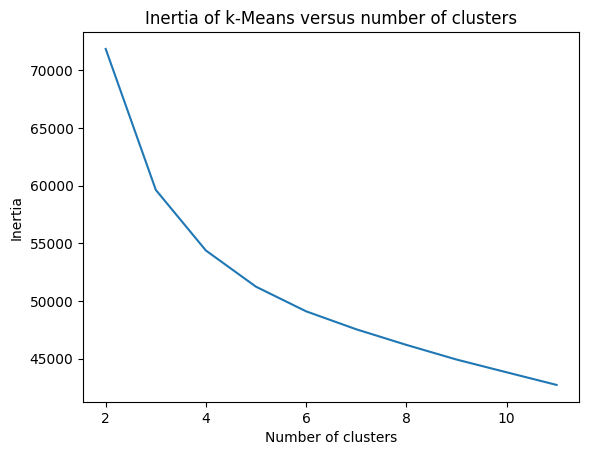

In [222]:
#Prueba: para elegir el hiperparámetro n_clusters, variando de 2 a 11 clusters
scores = [KMeans(n_clusters=i).fit(df_estandarizado).inertia_ for i in range(2,12)]

plt.plot(np.arange(2, 12), scores)
plt.xlabel('Number of clusters')
plt.ylabel("Inertia")
plt.title("Inertia of k-Means versus number of clusters")

La curva comienza aplanarse en K=4. A la vez, 4 son los grupos de posiciones disponibles para las jugadores (GK, Midfielder, Defender y Forward), por lo que guarda una estrecha relación.

In [223]:
# Número de clusters buscado
n_clust = 4
km = KMeans(n_clusters=n_clust)
km.fit(df_estandarizado) #utiliza las dimensiones númericas
df_clusters_kmean=df_estandarizado.copy()
df_clusters_kmean['kmeans_4'] = km.labels_ #clusters
df_clusters_kmean.head(4)

,overall,potential,age,height_cm,weight_kg,nationality_id,weak_foot,skill_moves,pace,shooting,passing,dribbling,defending,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,Position_Defender,Position_Forward,Position_GK,Position_Midfielder,preferred_foot_Left,preferred_foot_Right,work_rate_High/High,work_rate_High/Low,work_rate_High/Medium,work_rate_Low/High,work_rate_Low/Low,work_rate_Low/Medium,work_rate_Medium/High,work_rate_Medium/Low,work_rate_Medium/Medium,kmeans_4
0,2.854478,2.331503,0.470095,-0.032449,0.939197,2.336179,1.500438,1.594862,1.852515,2.129246,1.044709,2.342339e+00,-0.859305,2.020881,0.754001,1.706532,1.668241,0.668364,2.136912,1.375075,1.241432,1.095992,0.321579,1.354016,1.528971,1.240672,1.888014,2.397040,0.997692,1.957367,2.374596,1.378957,1.641415,1.618104,0.749745,-1.091169,1.661258,1.249883,1.208383,2.057368,-0.274810,-0.564853,-0.825436,-0.533468,-0.295144,-0.491900,-0.097488,-0.252705,-0.569110,1.535347,-0.373327,-0.710028,-0.460444,0.460444,4.625717,-0.177611,-0.477912,-0.127118,-0.024739,-0.1663,-0.271181,-0.173913,-1.218525,0
1,0.171675,0.383620,-0.195941,0.932182,1.119642,-1.080022,-0.104020,-0.678547,-0.314595,-1.026050,-0.352055,-2.151871e-01,0.960406,1.658219,0.222104,-0.446254,0.536610,0.496238,-0.205157,0.222127,-0.006104,-0.534929,0.597871,0.167149,0.048565,0.142442,0.583168,0.085353,-0.276642,-0.187167,0.748493,-0.047632,1.798702,-0.704400,1.169730,0.811069,-0.694399,-0.991725,-0.558439,-0.198873,0.983545,0.998355,1.074171,-0.244366,-0.491527,-0.392652,-0.484953,-0.394235,1.757128,-0.651319,-0.373327,-0.710028,-0.460444,0.460444,-0.216183,-0.177611,-0.477912,-0.127118,-0.024739,-0.1663,3.687576,-0.173913,-1.218525,3
2,-0.163676,-0.501782,0.026071,0.449866,1.300087,-0.722305,-0.104020,-0.678547,0.027581,-1.697390,-0.674385,7.206482e-03,1.015549,0.449347,-1.083460,-0.783946,0.684214,0.496238,-0.767253,0.360481,-1.004133,-0.317473,0.542612,0.528370,0.317730,0.279721,0.293202,0.450357,-1.471330,-1.811814,-0.781957,0.730507,0.304473,-0.793727,0.539752,0.890329,-1.199183,-0.022381,-0.159479,-0.339888,1.267690,0.878108,0.867692,-0.437101,-0.344240,-0.442276,-0.242788,-0.535765,1.757128,-0.651319,-0.373327,-0.710028,-0.460444,0.460444,-0.216183,-0.177611,-0.477912,-0.127118,-0.024739,-0.1663,3.687576,-0.173913,-1.218525,3
3,-0.163676,0.206540,-0.195941,2.218357,1.660977,-0.489788,-1.708478,-1.815251,0.000000,0.000000,0.000000,1.580202e-15,0.000000,0.000000,-2.050544,-1.670387,-2.267865,-2.028289,-1.797764,-1.991531,-1.752655,-1.948393,-1.888750,-2.258187,-2.172044,-1.504902,-1.591575,-1.009656,-1.949205,-0.447111,0.270227,-2.187516,-1.818904,-1.999642,-1.770168,-1.487469,-1.956359,-1.052309,-1.983295,-2.102576,-1.654941,-1.526828,-1.527465,2.791203,2.552401,2.684040,2.614765,2.672244,-0.569110,-0.651319,2.678619,-0.710028,-0.460444,0.460444,-0.216183,-0.177611,-0.477912,-0.127118,-0.024739,-0.1663,-0.271181,-0.173913,0.820665,2


### Mezcla de Gaussianas
Al igual que en Kmeans, el número de clusters es un hiperparámetro. Decidimos usar entonces 4 clusters para comparar el rendimiento de ambos métodos.

In [224]:
# Crear y ajustar el modelo de mezcla gaussiana
n_components = 4
gmm = GaussianMixture(n_components=n_components, random_state=0)
gmm.fit(df_estandarizado)

# Predecir las asignaciones de clúster para cada punto
labels = gmm.predict(df_estandarizado)
df_clusters_GM=df_estandarizado.copy()
df_clusters_GM['GM_4'] = labels #clusters
df_clusters_GM.head(4)

,overall,potential,age,height_cm,weight_kg,nationality_id,weak_foot,skill_moves,pace,shooting,passing,dribbling,defending,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,Position_Defender,Position_Forward,Position_GK,Position_Midfielder,preferred_foot_Left,preferred_foot_Right,work_rate_High/High,work_rate_High/Low,work_rate_High/Medium,work_rate_Low/High,work_rate_Low/Low,work_rate_Low/Medium,work_rate_Medium/High,work_rate_Medium/Low,work_rate_Medium/Medium,GM_4
0,2.854478,2.331503,0.470095,-0.032449,0.939197,2.336179,1.500438,1.594862,1.852515,2.129246,1.044709,2.342339e+00,-0.859305,2.020881,0.754001,1.706532,1.668241,0.668364,2.136912,1.375075,1.241432,1.095992,0.321579,1.354016,1.528971,1.240672,1.888014,2.397040,0.997692,1.957367,2.374596,1.378957,1.641415,1.618104,0.749745,-1.091169,1.661258,1.249883,1.208383,2.057368,-0.274810,-0.564853,-0.825436,-0.533468,-0.295144,-0.491900,-0.097488,-0.252705,-0.569110,1.535347,-0.373327,-0.710028,-0.460444,0.460444,4.625717,-0.177611,-0.477912,-0.127118,-0.024739,-0.1663,-0.271181,-0.173913,-1.218525,1
1,0.171675,0.383620,-0.195941,0.932182,1.119642,-1.080022,-0.104020,-0.678547,-0.314595,-1.026050,-0.352055,-2.151871e-01,0.960406,1.658219,0.222104,-0.446254,0.536610,0.496238,-0.205157,0.222127,-0.006104,-0.534929,0.597871,0.167149,0.048565,0.142442,0.583168,0.085353,-0.276642,-0.187167,0.748493,-0.047632,1.798702,-0.704400,1.169730,0.811069,-0.694399,-0.991725,-0.558439,-0.198873,0.983545,0.998355,1.074171,-0.244366,-0.491527,-0.392652,-0.484953,-0.394235,1.757128,-0.651319,-0.373327,-0.710028,-0.460444,0.460444,-0.216183,-0.177611,-0.477912,-0.127118,-0.024739,-0.1663,3.687576,-0.173913,-1.218525,0
2,-0.163676,-0.501782,0.026071,0.449866,1.300087,-0.722305,-0.104020,-0.678547,0.027581,-1.697390,-0.674385,7.206482e-03,1.015549,0.449347,-1.083460,-0.783946,0.684214,0.496238,-0.767253,0.360481,-1.004133,-0.317473,0.542612,0.528370,0.317730,0.279721,0.293202,0.450357,-1.471330,-1.811814,-0.781957,0.730507,0.304473,-0.793727,0.539752,0.890329,-1.199183,-0.022381,-0.159479,-0.339888,1.267690,0.878108,0.867692,-0.437101,-0.344240,-0.442276,-0.242788,-0.535765,1.757128,-0.651319,-0.373327,-0.710028,-0.460444,0.460444,-0.216183,-0.177611,-0.477912,-0.127118,-0.024739,-0.1663,3.687576,-0.173913,-1.218525,0
3,-0.163676,0.206540,-0.195941,2.218357,1.660977,-0.489788,-1.708478,-1.815251,0.000000,0.000000,0.000000,1.580202e-15,0.000000,0.000000,-2.050544,-1.670387,-2.267865,-2.028289,-1.797764,-1.991531,-1.752655,-1.948393,-1.888750,-2.258187,-2.172044,-1.504902,-1.591575,-1.009656,-1.949205,-0.447111,0.270227,-2.187516,-1.818904,-1.999642,-1.770168,-1.487469,-1.956359,-1.052309,-1.983295,-2.102576,-1.654941,-1.526828,-1.527465,2.791203,2.552401,2.684040,2.614765,2.672244,-0.569110,-0.651319,2.678619,-0.710028,-0.460444,0.460444,-0.216183,-0.177611,-0.477912,-0.127118,-0.024739,-0.1663,-0.271181,-0.173913,0.820665,2


##5- Análisis cualitativo de los clusters encontrados.


In [225]:
df_clusters_GM.groupby('GM_4').describe()

overall                                                              \
       count      mean       std       min       25%       50%       75%   
GM_4                                                                       
0      346.0 -0.085653  0.943349 -2.846479 -0.666701 -0.163676  0.507025   
1      245.0  0.401629  0.997725 -2.846479 -0.331351  0.339350  1.177726   
2      200.0 -0.120080  1.033379 -2.846479 -0.834376 -0.163676  0.507025   
3      844.0 -0.053018  0.989428 -2.846479 -0.666701 -0.163676  0.507025   

               potential                                                    \
           max     count      mean       std       min       25%       50%   
GM_4                                                                         
0     2.854478     346.0 -0.154786  0.919960 -3.335066 -0.855942 -0.147621   
1     2.854478     245.0  0.295441  1.001156 -2.272585 -0.324701  0.206540   
2     2.351452     200.0 -0.067935  0.926153 -2.803826 -0.678862 -0.147621   
3     3.022153     844.0 -0.006209  1.031605 -3.157986 -0.678862  0.029459   

                            age                                          \
           75%       max  count      mean       std       min       25%   
GM_4                                                                      
0     0.560700  2.331503  346.0  0.104995  1.013890 -2.194050 -0.639965   
1     0.914861  2.685664  245.0  0.106720  0.944345 -1.972038 -0.639965   
2     0.560700  1.977342  200.0  0.117096  1.108652 -1.972038 -0.639965   
3     0.737780  2.862744  844.0 -0.101770  0.974206 -1.972038 -0.861977   

                                   height_cm                                \
           50%       75%       max     count      mean       std       min   
GM_4                                                                         
0     0.026071  0.914120  3.356253     346.0  0.194769  0.913651 -2.444028   
1     0.026071  0.914120  2.690216     245.0 -0.226688  0.963004 -2.765571   
2     0.026071  0.914120  3.356253     200.0  0.920124  0.730986 -1.318624   
3    -0.195941  0.692107  2.912228     844.0 -0.232081  0.958136 -2.765571   

                                             weight_kg                      \
           25%       50%       75%       max     count      mean       std   
GM_4                                                                         
0    -0.474572  0.289094  0.771410  3.182988     346.0  0.148577  0.922124   
1    -0.836309 -0.353993  0.449866  2.379129     245.0 -0.251740  0.853803   
2     0.449866  0.771410  1.253726  3.182988     200.0  1.024006  0.873178   
3    -0.836309 -0.193221  0.329287  2.861444     844.0 -0.230489  0.933320   

                                                       nationality_id  \
           min       25%       50%       75%       max          count   
GM_4                                                                    
0    -2.308813 -0.504363  0.127194  0.758752  3.284982          346.0   
1    -2.489258 -0.865253 -0.143473  0.217417  2.202312          245.0   
2    -1.045698  0.397862  0.939197  1.660977  4.187207          200.0   
3    -2.850148 -0.865253 -0.323918  0.397862  3.645872          844.0   

                                                                            \
          mean       std       min       25%       50%       75%       max   
GM_4                                                                         
0     0.051595  1.015507 -1.080022 -0.829620 -0.346701  0.547592  2.389836   
1    -0.217558  0.888866 -1.080022 -0.829620 -0.507674  0.100445  2.389836   
2    -0.003382  1.017531 -1.080022 -0.829620 -0.346701  0.332962  2.389836   
3     0.042804  1.013745 -1.026364 -0.775962 -0.346701  0.547592  2.389836   

     weak_foot                                                             \
         count      mean       std       min       25%      50%       75%   
GM_4                                                                        
0        346.0 

In [226]:
df_clusters_kmean.groupby('kmeans_4').describe()

overall                                                              \
           count      mean       std       min       25%       50%       75%   
kmeans_4                                                                       
0          472.0  0.742197  0.855730 -1.169727  0.171675  0.674700  1.345401   
1          459.0 -0.386147  0.833492 -2.846479 -0.834376 -0.331351  0.171675   
2          200.0 -0.120080  1.033379 -2.846479 -0.834376 -0.163676  0.507025   
3          504.0 -0.295753  0.873741 -2.846479 -0.834376 -0.331351  0.171675   

                   potential                                          \
               max     count      mean       std       min       25%   
kmeans_4                                                               
0         3.022153     472.0  0.555823  0.972399 -1.564263 -0.147621   
1         2.016102     459.0 -0.250243  0.938184 -3.157986 -0.855942   
2         2.351452     200.0 -0.067935  0.926153 -2.803826 -0.678862   
3         2.351452     504.0 -0.265675  0.897048 -3.335066 -0.855942   

                                          age                                \
               50%       75%       max  count      mean       std       min   
kmeans_4                                                                      
0         0.560700  1.269021  2.862744  472.0  0.256550  0.936419 -1.972038   
1        -0.324701  0.383620  2.331503  459.0 -0.252049  0.955794 -1.972038   
2        -0.147621  0.560700  1.977342  200.0  0.117096  1.108652 -1.972038   
3        -0.324701  0.383620  2.154423  504.0 -0.057183  0.991393 -2.194050   

                                                 height_cm            \
               25%       50%       75%       max     count      mean   
kmeans_4                                                               
0        -0.417953  0.248083  0.914120  2.912228     472.0 -0.183003   
1        -1.083989 -0.195941  0.470095  2.468204     459.0 -0.294098   
2        -0.639965  0.026071  0.914120  3.356253     200.0  0.920124   
3        -0.861977  0.026071  0.692107  3.356253     504.0  0.074094   

                                                                      \
               std       min       25%       50%       75%       max   
kmeans_4                                                               
0         0.944977 -2.765571 -0.836309 -0.193221  0.449866  3.022216   
1         0.981316 -2.765571 -0.997081 -0.353993  0.289094  2.861444   
2         0.730986 -1.318624  0.449866  0.771410  1.253726  3.182988   
3         0.934671 -2.444028 -0.514765  0.128323  0.771410  3.182988   

         weight_kg                                                    \
             count      mean       std       min       25%       50%   
kmeans_4                                                               
0            472.0 -0.248988  0.897293 -2.850148 -0.865253 -0.323918   
1            459.0 -0.246865  0.972542 -2.850148 -0.955476 -0.323918   
2            200.0  1.024006  0.873178 -1.045698  0.397862  0.939197   
3            504.0  0.051651  0.894612 -1.947923 -0.504363 -0.143473   

                             nationality_id                                \
               75%       max          count      mean       std       min   
kmeans_4                                                                    
0         0.262528  3.645872          472.0 -0.164053  0.906177 -1.026364   
1         0.397862  2.924092          459.0  0.159519  1.050066 -1.026364   
2         1.660977  4.187207          200.0 -0.003382  1.017531 -1.080022   
3         0.578307  3.284982          504.0  0.009703  1.009650 -1.080022   

                                                 weak_foot            \
               25%       50%       75%       max     count      mean   
kmeans_4                                                               
0        -0.829620 -0.471902  0.100445  2.389836     472.0  0.351483   
1        -0.713362 -0.221500  0.690679  2.3898

In [227]:
df_clusters_GM_position_name = pd.concat ([df_clusters_GM, col_position, col_name],axis=1)
df_clusters_kmean_position_name = pd.concat ([df_clusters_kmean, col_position, col_name],axis=1)

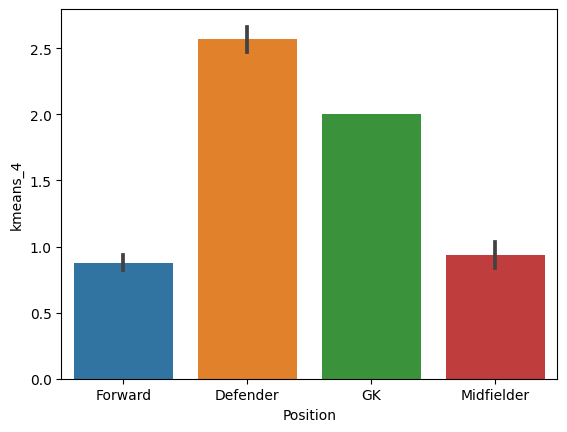

In [228]:
sns.barplot(data=df_clusters_kmean_position_name, x='Position', y='kmeans_4')
plt.show()

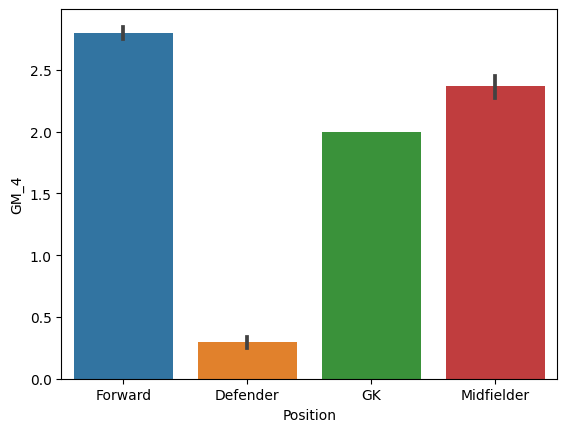

In [229]:
sns.barplot(data=df_clusters_GM_position_name, x='Position', y='GM_4')
plt.show()

A través de estos gráficos de barra, pudimos observar que tanto kmeans como mezcla de gaussianas clusterizaron de manera similar a la esperada según la posición. Esto se observa de manera clara para las arqueras, las cuales forman un solo cluster,el número 2, con ambas metodologías de clustering.

Para kmeans podemos decir que:
 - Cluster 0 y 1: mayoritariamente es una mezcla entre delanteras y mediocampistas
 - Cluster 2: arqueras
 - Cluster 3: en su mayoría son defensoras


Para mezcla de Gaussianas (GM) podemos decir que:
 - Cluster 0: en su mayoría son defensoras
 - Cluster 1: es una mezcla entre defensoras, delanteras y mediocampistas
 - Cluster 2: arqueras
 - Cluster 3: es una mezcla de delanteras y mediocampistas


<Axes: xlabel='skill_ball_control', ylabel='power_shot_power'>

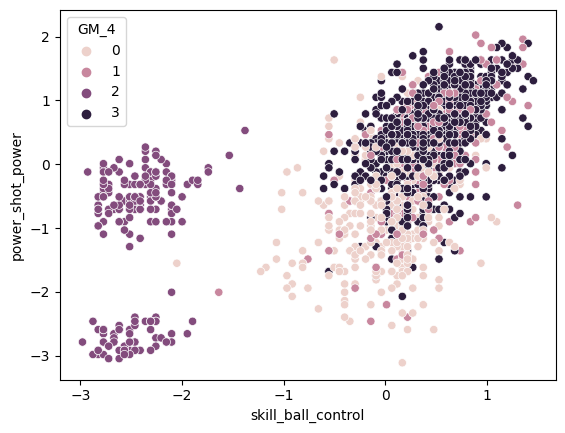

In [230]:
sns.scatterplot(x='skill_ball_control', y='power_shot_power', hue='GM_4', data=df_clusters_GM)

Los clusters encontrados por Mezcla de Gausseanas no parecen distinguir entre los 2 grupos que se visualizan con bajo *skill_ball_control* cuando graficamos esta variable contra *power_shot_power*. Es decir, se nota cierta separación espacial pero se mantienen dentro del mismo cluster (cluster 2), el cual está formado por arqueras. Por las características de la posición es deseable que tengan alta fuerza en el disparo, aunque eso no ocurra.
Dentro de los otros clusters, podemos ver que el 0 posee menos potencia y tiene sentido ya que la mayoría son defensoras, mientras que el 3 tiene mayor control de balón y mayor potencia, lo cual también tiene sentido ya que la mayoría de las delanteras están en ese cluster.

<Axes: xlabel='skill_ball_control', ylabel='power_shot_power'>

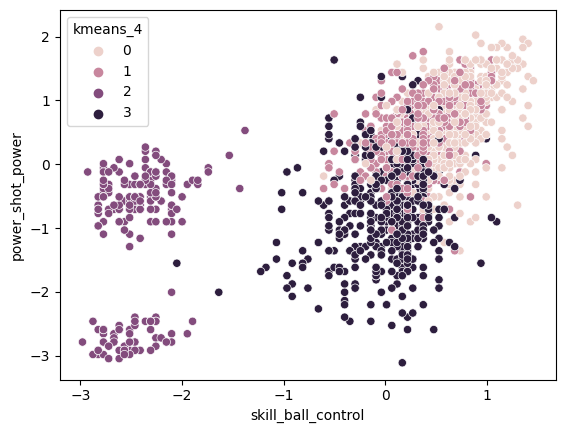

In [231]:
sns.scatterplot(x='skill_ball_control', y='power_shot_power', hue='kmeans_4', data=df_clusters_kmean)

Los clusters encontrados por kmeans muestran algo muy similar a la mezcla de gausianas, aunque acá parecen separarse un poco mejor.

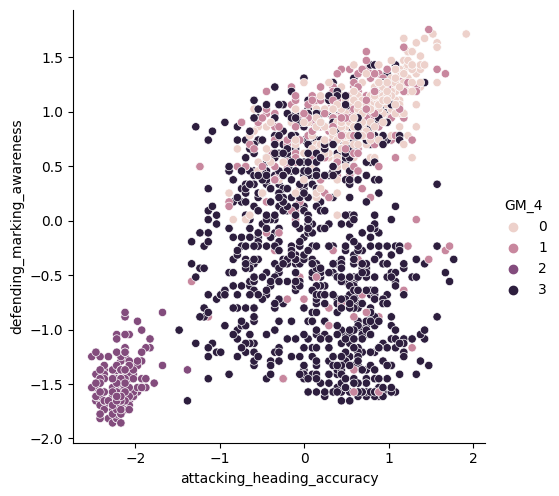

In [232]:
sns.pairplot(df_clusters_GM, x_vars=["attacking_heading_accuracy"], y_vars=["defending_marking_awareness"], hue="GM_4", height=5 ) #,plot_kws={'s': 10}

Con mezcla de guasianas, nuevamente el cluster 2 es el que más se separa y es el de las arqueras.
Podemos ver que el cluster 0 1 son los que presentan mejor defensa, lo cual tiene sentido ya que todas las defensoras se encuentran entre estos 2 clusters.

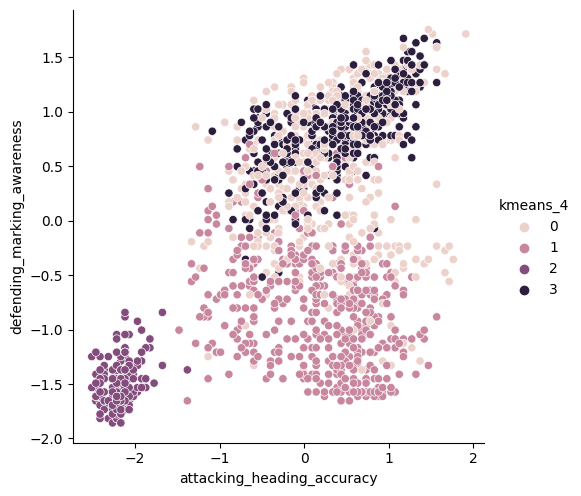

In [233]:
sns.pairplot(df_clusters_kmean, x_vars=["attacking_heading_accuracy"], y_vars=["defending_marking_awareness"], hue="kmeans_4", height=5)

Kmeans también distingue al conjunto separado como un solo cluster, que es el de las arqueras. A diferencia con GM, el cluster 1 acá queda más dificil de localizar.

##6- Uso de alguna transformación (proyección, Embedding)

###t-SNE

In [234]:
df_clusters_kmean_position_name = pd.concat ([df_clusters_kmean, col_position, col_name],axis=1)

In [235]:
time_start = time.time()

tsne = manifold.TSNE(n_components=2, verbose=1,perplexity=30, n_iter=1000)
df_clusters_kmean_tsne = tsne.fit_transform(df_clusters_kmean)

print ('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1635 samples in 0.002s...
[t-SNE] Computed neighbors for 1635 samples in 0.078s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1635
[t-SNE] Computed conditional probabilities for sample 1635 / 1635
[t-SNE] Mean sigma: 2.129541
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.133835
[t-SNE] KL divergence after 1000 iterations: 0.931457
t-SNE done! Time elapsed: 12.106575012207031 seconds


In [236]:
layout = go.Layout(title="Visualización de la base en el espacio tsne para clusters kmeans",titlefont=dict(size=20),
                xaxis=dict(title='componente 1'),
                yaxis=dict(title='componente 2'),
                autosize=False, width=1000,height=800)

# Etiquetas de cluster
cluster_labels = df_clusters_kmean_position_name["kmeans_4"]

# Colores para cada cluster
cluster_colors = ['blue', 'green', 'red', 'purple']  # Define los colores que quieras

# Crear una lista de objetos Scatter para cada cluster
cluster_scatters = []
for cluster_id, color in zip(cluster_labels.unique(), cluster_colors):
    cluster_data = df_clusters_kmean_tsne[cluster_labels == cluster_id]
    cluster_positions = df_clusters_kmean_position_name.loc[cluster_labels == cluster_id, 'Position']

    cluster_scatter = go.Scatter(
        x=cluster_data[:, 0],
        y=cluster_data[:, 1],
        mode='markers',
        text=cluster_positions,
        marker=dict(size=5, color=color),
        name=f'Cluster {cluster_id}'
    )
    cluster_scatters.append(cluster_scatter)

# Agregar todos los objetos Scatter al data
data3 = cluster_scatters


# Crea el gráfico
fig = go.Figure(data=data3, layout=layout)
fig.show(renderer="colab")

In [237]:
df_clusters_GM_position_name = pd.concat ([df_clusters_GM, col_position, col_name],axis=1)

In [ ]:
time_start = time.time()

tsne = manifold.TSNE(n_components=2, verbose=1,perplexity=30, n_iter=1000)
df_clusters_GM_tsne = tsne.fit_transform(df_clusters_GM)

print ('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1635 samples in 0.001s...
[t-SNE] Computed neighbors for 1635 samples in 0.091s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1635
[t-SNE] Computed conditional probabilities for sample 1635 / 1635
[t-SNE] Mean sigma: 2.115992
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.853363


In [ ]:
layout = go.Layout(title="Visualización de la base en el espacio tsne para clusters GM",titlefont=dict(size=20),
                xaxis=dict(title='componente 1'),
                yaxis=dict(title='componente 2'),
                autosize=False, width=1000,height=800)

# Etiquetas de cluster
cluster_labels2 = df_clusters_GM_position_name["GM_4"]

# Colores para cada cluster
cluster_colors = ['blue', 'green', 'red', 'purple']  # Define los colores que quieras

# Crear una lista de objetos Scatter para cada cluster
cluster_scatters2 = []
for cluster_id, color in zip(cluster_labels2.unique(), cluster_colors):
    cluster_data2 = df_clusters_GM_tsne[cluster_labels2 == cluster_id]
    cluster_positions2 = df_clusters_GM_position_name.loc[cluster_labels2 == cluster_id, 'Position']

    cluster_scatter2 = go.Scatter(
        x=cluster_data2[:, 0],
        y=cluster_data2[:, 1],
        mode='markers',
        text=cluster_positions2,
        marker=dict(size=5, color=color),
        name=f'Cluster {cluster_id}'
    )
    cluster_scatters2.append(cluster_scatter2)


# Agregar todos los objetos Scatter al data
data_GM = cluster_scatters2


# Crea el gráfico
fig = go.Figure(data=data_GM, layout=layout)
fig.show(renderer="colab")

In [ ]:
df_position_name = pd.concat ([df_estandarizado, col_position, col_name],axis=1)

In [ ]:
time_start = time.time()

tsne = manifold.TSNE(n_components=2, verbose=1,perplexity=30, n_iter=1000)
df_tsne = tsne.fit_transform(df_estandarizado)

print ('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

In [ ]:
layout = go.Layout(title="Visualización de la base en el espacio tsne para posiciones",titlefont=dict(size=20),
                xaxis=dict(title='componente 1'),
                yaxis=dict(title='componente 2'),
                autosize=False, width=1000,height=800)

# Etiquetas de posicion
position_labels = df_clusters_GM_position_name["Position"]

# Colores para cada posicion
position_colors = ['blue', 'green', 'red', 'purple']  # Define los colores que quieras

# Crear una lista de objetos Scatter para cada cluster
position_scatters = []
for position_id, color in zip(position_labels.unique(), position_colors):
    position_data = df_clusters_GM_tsne[position_labels == position_id]
    posit_cluster = df_clusters_GM_position_name.loc[position_labels == position_id, 'GM_4']

    position_scatter = go.Scatter(
        x=position_data[:, 0],
        y=position_data[:, 1],
        mode='markers',
        text=posit_cluster,
        marker=dict(size=5, color=color),
        name=f'Posicion {position_id}'
    )
    position_scatters.append(position_scatter)


# Agregar todos los objetos Scatter al data
data_GM_pos = position_scatters


# Crea el gráfico
fig = go.Figure(data=data_GM_pos, layout=layout)
fig.show(renderer="colab")

La ventaja de utilizar tsne como embedding es que facilita la visualización y con este fin lo utilizamos para llegar a conclusiones más acertadas y medir la presicion de cada metodo utilizado.
En el ultimo grafico podemos ver una visualizacion en 2 dimensiones donde cada color corresponde a una posicion de jugadora.
Ambos métodos clusterizan diferente. Kmeans es mas rigido mientras que GM pueden "mezclar" datos próximos, por eso vemos por ejemplo el punto azul entre los violetas. Sin embargo, ambos comenten error en la clusterizacion de mediocampistas y delanteras. Por un lado GM mezcla más a estos grupos, mientras que por otro Kmeans asigna incorrectamente defensoras, cluster donde es mas preciso GM. Estos datos nos refuerzan la visualizacion realizada con el grafico de barras.